# Poisson neurons
Can convert input probabilities to spikes. Useful for doing things like converting images to spike trains, by repeatedly showing the same image to a model.

In [1]:
import numpy as np
from spikeflow import BPNNModel, PoissonNeuronLayer
import spikeflow.drawing_utils.trace_renderers as rend

/Applications/Anaconda/anaconda/envs/mlbook/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Run fake data through a small poisson layer

## Create a model layer with 3 Poisson neurons in a single layer

In [2]:
model_input_shape = (5,)

pn = PoissonNeuronLayer('pn', model_input_shape[0])

model = BPNNModel.compiled_model(model_input_shape, [pn], [])

## Run the model for 1000 timesteps

In [3]:
traces = []

def end_time_step_callback(i, graph, sess, results):
    traces.append(results)
    
def data_generator():
    z = np.zeros(5,)
    p = np.array([0.0, 0.25, 0.5, 0.75, 1.0])
    for i in range(0, 2000):
        if i < 200 or i > 1800: yield z
        else: yield p
    
model.run_time(data_generator(), end_time_step_callback)

## Display input and firings for each neuron

Total:


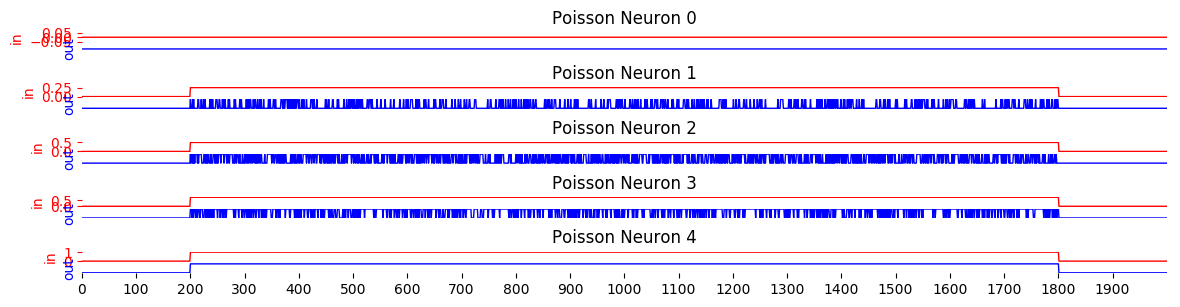

Closeup (timesteps 180-260):


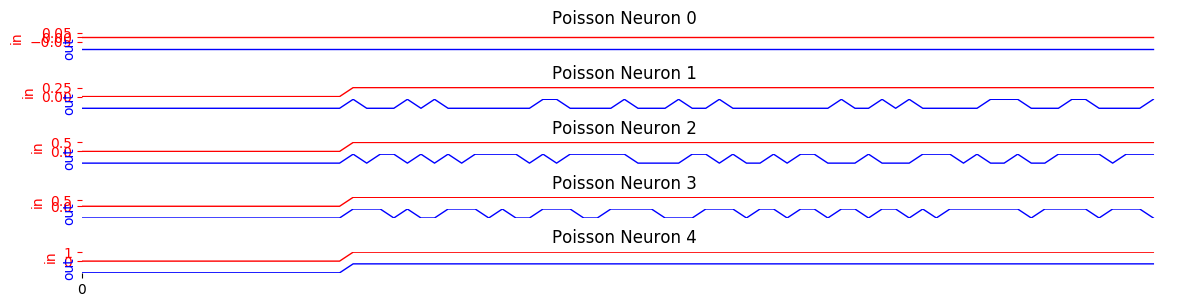

some neuron traces from [195:215,:,2]:  shape (2000, 2, 5)
[[0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.5 1. ]
 [0.5 0. ]
 [0.5 1. ]
 [0.5 1. ]
 [0.5 0. ]
 [0.5 1. ]
 [0.5 0. ]
 [0.5 1. ]
 [0.5 0. ]
 [0.5 1. ]
 [0.5 1. ]
 [0.5 1. ]
 [0.5 1. ]
 [0.5 0. ]
 [0.5 1. ]]


In [4]:
neuron_layer_0_traces = np.array([r['pn'] for r in traces])

print('Total:')
rend.render_figure([rend.IdentityNeuronTraceRenderer(neuron_layer_0_traces, 'Poisson Neuron')], 
                   0, 2000)

print('Closeup (timesteps 180-260):')
rend.render_figure([rend.IdentityNeuronTraceRenderer(neuron_layer_0_traces, 'Poisson Neuron')], 
                   180, 260)

print('some neuron traces from [195:215,:,2]:  shape', neuron_layer_0_traces.shape)
print(neuron_layer_0_traces[195:215,:,2])

# Run an image through a poisson layer

## Get the first mnist image, display it

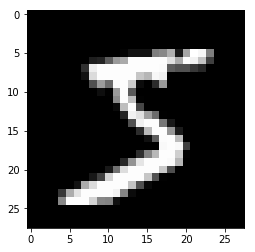

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt

mnist = tf.keras.datasets.mnist
(x_train, _),(_, _) = mnist.load_data()
x_train = x_train / 255.0
first_image = x_train[0,:,:]

plt.imshow(first_image.reshape((28, 28)), cmap='gray')
plt.show()

## Make a model of 784 poisson neurons, that will take the image as input

In [6]:
n2 = 28*28

model2_input_shape = (n2,)

pnl = PoissonNeuronLayer('pnl', model2_input_shape[0])

model2 = BPNNModel.compiled_model(model2_input_shape, [pnl], [])

## A data generator that will yield some zeros, then the image (scaled) for a while, then more zeros

In [7]:
def data_from_image_generator(scale, 
                              image, 
                              initially_quiescent_timesteps, 
                              active_timesteps, 
                              finally_quiescent_timesteps):
    z = np.zeros(n2,)
    im = image.ravel() * scale
    for i in range(initially_quiescent_timesteps): yield z 
    for i in range(active_timesteps): yield im 
    for i in range(finally_quiescent_timesteps): yield z        

## Run the model, extract data

In [8]:
traces2 = []
def end_time_step_callback2(i, graph, sess, results):
    traces2.append(results)
    
scale = 0.2
model2.run_time(data_from_image_generator(scale, first_image, 200, 600, 200), end_time_step_callback2)

## Convert the firings to firing rates, and reconstruct the image from those

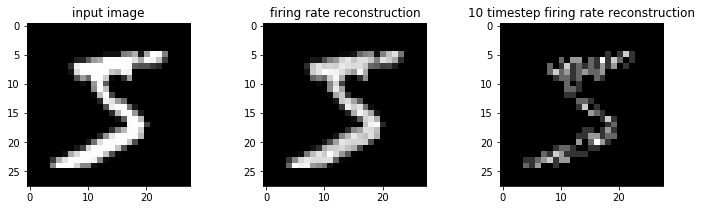

max middle_input:  0.2
max firing rate, all:  0.137
max firing rate, partial:  0.5


In [9]:
poisson_layer_traces = np.array([r['pnl'] for r in traces2])

input_traces = poisson_layer_traces[:,0,:]
output_traces = poisson_layer_traces[:,1,:]
output_traces_partial = poisson_layer_traces[200:210,1,:]

middle_input = input_traces[200,:]
firing_rates_all = np.mean(output_traces, axis=0)
firing_rates_partial = np.mean(output_traces_partial, axis=0)

middle_input_pixels = middle_input.reshape((28, 28))
recovered_pixels_all = firing_rates_all.reshape((28, 28)) / scale
recovered_pixels_partial = firing_rates_partial.reshape((28, 28)) / scale

f, axarr = plt.subplots(1,3, figsize=(12, 3))
axarr[0].set_title('input image')
axarr[0].imshow(middle_input_pixels, cmap='gray')
axarr[1].set_title('firing rate reconstruction')
axarr[1].imshow(recovered_pixels_all, cmap='gray')
axarr[2].set_title('10 timestep firing rate reconstruction')
axarr[2].imshow(recovered_pixels_partial, cmap='gray')
plt.show()

print('max middle_input: ', np.max(middle_input))
print('max firing rate, all: ', np.max(firing_rates_all))
print('max firing rate, partial: ', np.max(firing_rates_partial))

## For good measure, display spikes for some interesting neurons

Neuron patch 200:210, All timesteps:


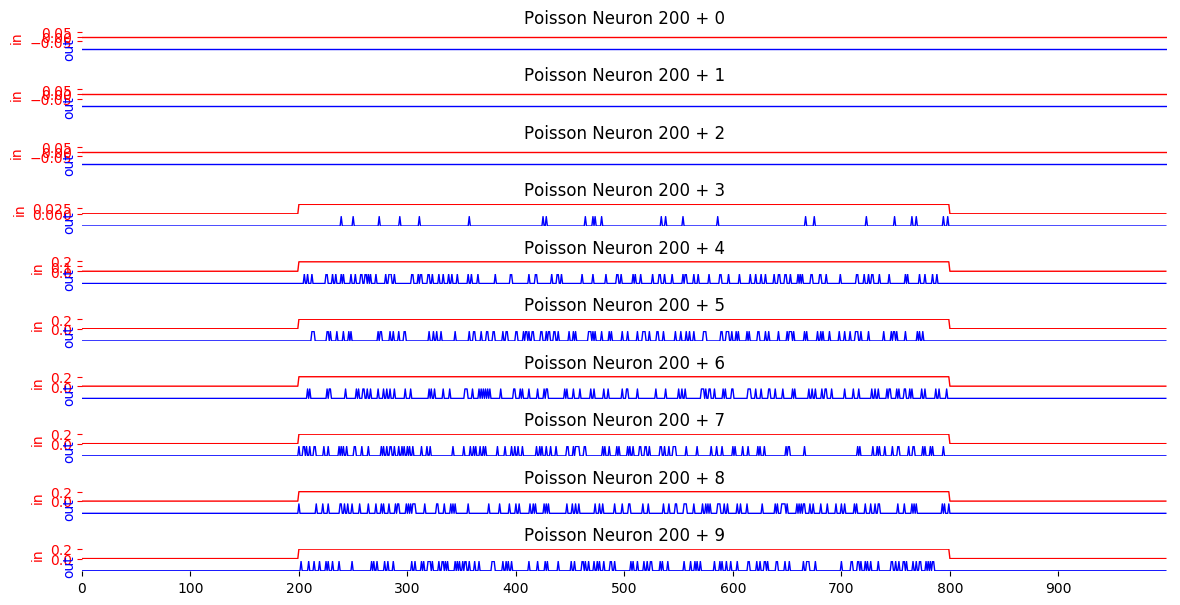

In [10]:
neuron_patch = poisson_layer_traces[:,:,200:210]

print('Neuron patch 200:210, All timesteps:')
rend.render_figure([rend.IdentityNeuronTraceRenderer(neuron_patch, 'Poisson Neuron 200 +')], 
                   0, 1000)